<a href="https://colab.research.google.com/github/NID123-CH/Pytorch-and-Image-Processing/blob/main/finetuning_vit_with_huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install datasets transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Load the dataset.

In [ ]:
from datasets import load_dataset

dataset_name = "beans"
dataset = load_dataset(dataset_name)
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/bean_rust/bean_rust_train.75.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7B6F9ECB6C50>, 'labels': 1}


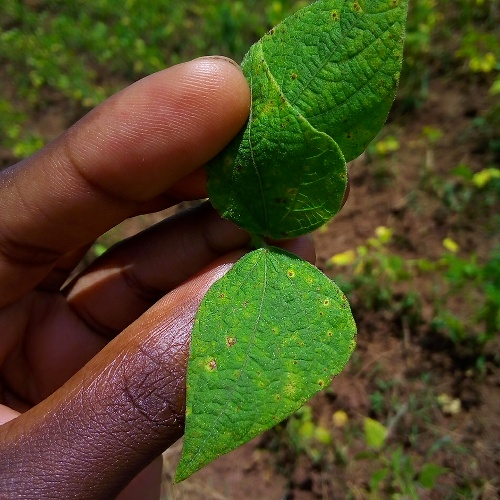

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)
bean_rust


In [ ]:
from IPython.display import display

index = 666
example = dataset["train"][index]
print(example)

image = example["image"]
display(image)

labels = dataset["train"].features["labels"]
print(labels)

readable_label = labels.int2str(example["labels"])
print(readable_label)

## Loading the feature extractor.

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


If we print a feature extractor, we can see its configuration.

In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


In [ ]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.6549, -0.6000, -0.5294,  ..., -0.4431, -0.4510, -0.4980],
          [-0.6235, -0.6000, -0.5373,  ..., -0.4824, -0.5059, -0.5608],
          [-0.5843, -0.5608, -0.5294,  ..., -0.4667, -0.5294, -0.6157],
          ...,
          [-0.0353, -0.0118,  0.0118,  ..., -0.3490, -0.4745, -0.6941],
          [-0.1059, -0.1137, -0.0039,  ..., -0.2784, -0.3882, -0.5529],
          [-0.1922, -0.2078, -0.1608,  ..., -0.2392, -0.2941, -0.4667]],

         [[-0.4431, -0.3961, -0.3490,  ..., -0.3882, -0.4588, -0.5373],
          [-0.4431, -0.4118, -0.3569,  ..., -0.4431, -0.5137, -0.5843],
          [-0.4510, -0.4039, -0.3490,  ..., -0.4510, -0.5294, -0.6314],
          ...,
          [-0.3255, -0.3098, -0.2863,  ..., -0.4980, -0.6000, -0.8039],
          [-0.4196, -0.4431, -0.3333,  ..., -0.4118, -0.5216, -0.6784],
          [-0.5216, -0.5529, -0.5137,  ..., -0.3647, -0.4196, -0.6000]],

         [[-0.9451, -0.9059, -0.8510,  ..., -0.7333, -0.7255, -0.7725],
          [-0

## Preprocess the dataset.

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
process_example(dataset['train'][0])

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

While we could call `ds.map` and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, we'll apply a ***transform*** to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [ ]:
dataset = load_dataset(dataset_name)
dataset = dataset["train"]
dataset = dataset.train_test_split(0.2)

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_dataset = dataset.with_transform(transform)
prepared_dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 827
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 207
    })
})

In [ ]:
prepared_dataset = dataset.with_transform(transform)

In [ ]:
prepared_dataset["train"][0:2]

{'pixel_values': tensor([[[[ 0.0588,  0.0275,  0.0510,  ..., -0.5216, -0.5373, -0.5137],
          [ 0.1059,  0.0980,  0.0902,  ..., -0.4824, -0.5216, -0.5529],
          [ 0.0824,  0.0980,  0.0824,  ..., -0.4588, -0.4667, -0.5373],
          ...,
          [-0.2941, -0.1451,  0.0118,  ..., -0.4118, -0.4353, -0.4667],
          [ 0.0431,  0.1451,  0.0980,  ..., -0.2863, -0.2784, -0.2392],
          [ 0.2941,  0.2784,  0.1294,  ...,  0.0039,  0.0824,  0.1294]],

         [[-0.4902, -0.4745, -0.2157,  ..., -0.4196, -0.4118, -0.3804],
          [-0.4431, -0.3882, -0.1608,  ..., -0.3961, -0.4196, -0.4588],
          [-0.4588, -0.3569, -0.1294,  ..., -0.3725, -0.3882, -0.4588],
          ...,
          [-0.7020, -0.6078, -0.5059,  ..., -0.1451, -0.1686, -0.1765],
          [-0.4510, -0.3725, -0.4353,  ..., -0.1843, -0.2078, -0.1843],
          [-0.2000, -0.2314, -0.3804,  ..., -0.2157, -0.2157, -0.1843]],

         [[-0.4745, -0.4902, -0.4353,  ..., -0.7569, -0.7647, -0.7333],
          [-0

## Training

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [ ]:
!pip install evaluate



In [ ]:
import numpy as np
from evaluate import load

metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

## Load the pretrained Vision Transformer

In [ ]:
from transformers import ViTForImageClassification

labels = dataset['train'].features['labels'].names
print(labels)

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

['angular_leaf_spot', 'bean_rust', 'healthy']


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=128,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_dataset["train"],
    eval_dataset=prepared_dataset["test"],
    tokenizer=feature_extractor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 238740629GF
  train_loss               =      0.2919
  train_runtime            =  0:01:03.75
  train_samples_per_second =      51.885
  train_steps_per_second   =       0.439


In [ ]:
metrics = trainer.evaluate(prepared_dataset['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9662
  eval_loss               =     0.1331
  eval_runtime            = 0:00:02.53
  eval_samples_per_second =     81.622
  eval_steps_per_second   =     10.252


http://2.bp.blogspot.com/_EWuR-VzwybY/TTgPAMlniYI/AAAAAAAAEmk/qFOyCxy9I34/s1600/P1015765.JPG


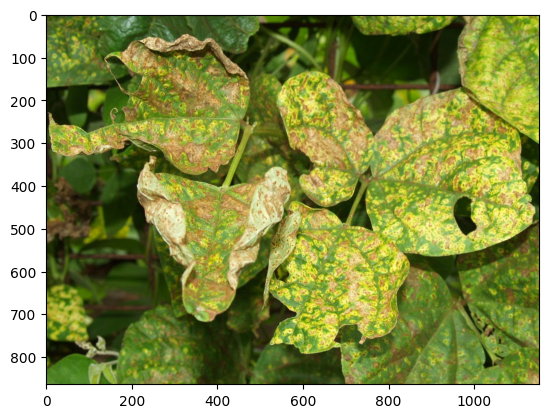

torch.Size([1, 3, 224, 224])
0
angular_leaf_spot

https://upload.wikimedia.org/wikipedia/commons/a/ac/Soybean_leaves.jpg


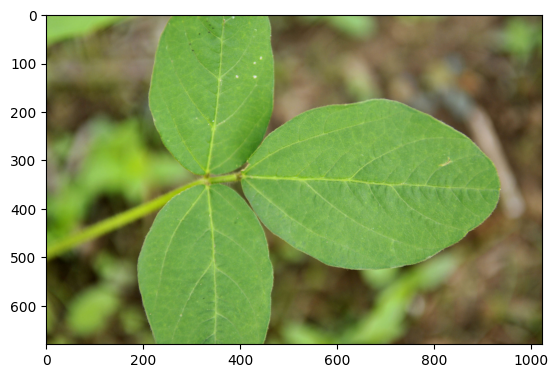

torch.Size([1, 3, 224, 224])
1
bean_rust



In [ ]:
import requests
import matplotlib.pyplot as plt
import urllib
import io
from PIL import Image

urls = [
    "http://2.bp.blogspot.com/_EWuR-VzwybY/TTgPAMlniYI/AAAAAAAAEmk/qFOyCxy9I34/s1600/P1015765.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/a/ac/Soybean_leaves.jpg"
]

for url in urls:
    print(url)
    with urllib.request.urlopen(url) as url:
        file = io.BytesIO(url.read())

    image = Image.open(file)
    plt.imshow(image)
    plt.show()

    #image = Image.open(requests.get(url, stream=False))
    features = feature_extractor(images=image, return_tensors="pt")
    print(features["pixel_values"].shape)/Users/markus/Development/dsr/Advanced-Computer-Vision/Module 2 - R-CNN/Solutions/0 - Object Detection intro and IoU Solution.ipynb
    pixel_values = features["pixel_values"].cuda()

    outputs = model(pixel_values)
    output = outputs[0].cpu().detach().numpy()[0]
    plt.show()

    logits = outputs.logits
    predicted_class_index = logits.argmax(-1).item()
    print(predicted_class_index)
    label = labels[predicted_class_index]
    print(label)
    print("")
